# What's in this notebook?
* Initial exploration of [torchgeo](https://github.com/microsoft/torchgeo/) to create a GeoDataset or similar PyTorch dataset
* Goals (implement in separate python script):
    * dataset has N tiles each with stack of rasters (initial DSM, stereo imagesground truth, many others)
    * be able to split those into train-val-test
    * Dataloader should pull 256x256px chunks out of all tiles in a dataset without me having to do math (i.e. use [RandomBatchGeoSampler](https://torchgeo.readthedocs.io/en/latest/api/samplers.html#torchgeo.samplers.RandomBatchGeoSampler) or similar)
    * Apply augmentations if needed
    * Make it easy to add new areas (South Cascade next?) & new rasters to the stack
* Other stuff
    * Plot output of `pc_laz_prep_full.sh` or other scripts before feeding results to torchgeo dataset

In [4]:
import os
import tempfile

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

import matplotlib.pyplot as plt


import glob
# Just to import ResDepth model for quick test
import sys
sys.path.insert(0, "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/ResDepth/")
from lib.UNet import UNet
import torch
import numpy as np


from torchgeo.samplers import RandomBatchGeoSampler
import pprint
from matplotlib_scalebar.scalebar import ScaleBar
import rioxarray
import math

In [10]:
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip")
naip_url = "https://naipblobs.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

naip = NAIP(naip_root)

  0%|          | 0/581769974 [00:00<?, ?it/s]

Using downloaded and verified file: /tmp/naip/m_3807511_se_18_060_20181104.tif
Using downloaded and verified file: /tmp/naip/m_3807512_nw_18_060_20180815.tif


  0%|          | 0/569661931 [00:00<?, ?it/s]

In [4]:
chesapeake_root = os.path.join(data_root, "chesapeake")

chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

  0%|          | 0/287350495 [00:00<?, ?it/s]

In [11]:
dataset = naip & chesapeake

## Visualize samples (each tile should have multiple pixel-aligned rasters)

In [29]:
sampler = RandomGeoSampler(naip, size=1000, length=4)

In [30]:
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

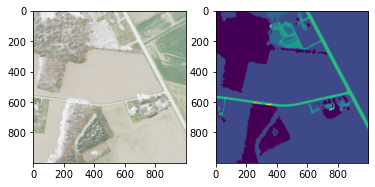

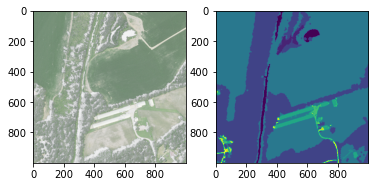

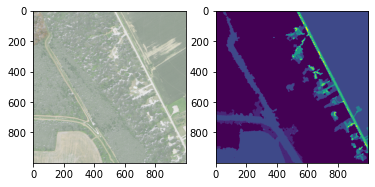

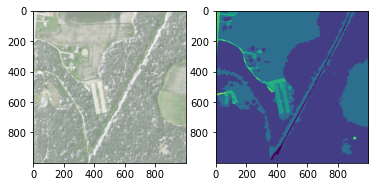

In [31]:
for sample in dataloader:
    image = sample["image"]
    target = sample["mask"]
    # print(image)
    # print(image.shape)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image.numpy().squeeze().transpose(1,2,0))
    ax[1].imshow(target.numpy().squeeze())
    plt.show()

## Make sure batch loading also works

In [38]:
sampler = RandomBatchGeoSampler(dataset, size=256, batch_size=2, length=10, roi=None)#, units=Units.PIXELS)

In [41]:
dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=stack_samples)

torch.Size([2, 4, 256, 256])


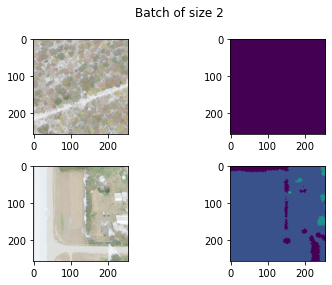

torch.Size([2, 4, 256, 256])


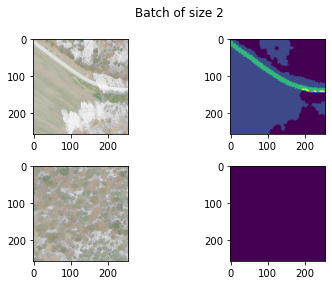

torch.Size([2, 4, 256, 256])


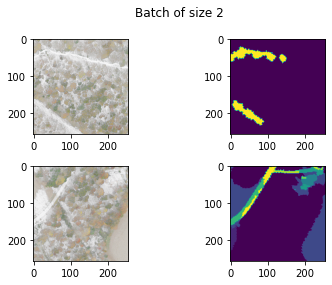

torch.Size([2, 4, 256, 256])


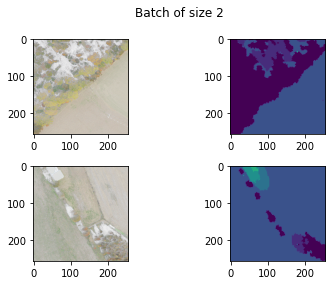

torch.Size([2, 4, 256, 256])


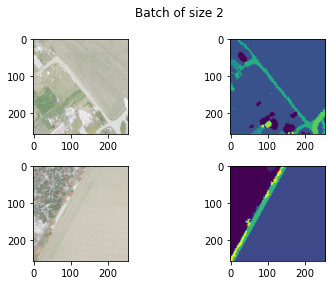

In [46]:
for sample in dataloader:
    image = sample["image"]
    target = sample["mask"]
    # print(image)
    # print(image.shape)
    print(image.shape)
    fig, ax = plt.subplots(2,2)
    plt.suptitle(f"Batch of size {image.shape[0]}")
    ax[0][0].imshow(image[0].numpy().squeeze().transpose(1,2,0))
    ax[0][1].imshow(target[0].numpy().squeeze())
    ax[1][0].imshow(image[1].numpy().squeeze().transpose(1,2,0))
    ax[1][1].imshow(target[1].numpy().squeeze())
    plt.tight_layout()
    plt.show()

In [69]:
run_folder = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all//resdepth-output/2021-09-30_14-15_ResDepth-stereo/"
def call_model(model, model_input_tensor : torch.Tensor):
    """Helper: given pytorch model & input rasters, return model output as numpy array"""
    # model_input = np.stack(inputs)
    # # print(model_input.shape)
    # model_input_tensor = torch.tensor(model_input).unsqueeze(0)
    tile_output = model(model_input_tensor).detach().numpy().squeeze()
    return tile_output
run_name = os.path.basename(run_folder) # save this for plotting
# !ls -l $run_folder/checkpoints
resdepth_state_dict = torch.load(run_folder + "/checkpoints/Model_best.pth")
print("Loaded best model from epoch", resdepth_state_dict['epoch'])
model_args = {'n_input_channels': 3, 'start_kernel': 64, 'depth': 5, 'act_fn_encoder': 'relu', 'act_fn_decoder': 'relu', 'act_fn_bottleneck': 'relu', 'up_mode': 'transpose', 'do_BN': True, 'outer_skip': True, 'outer_skip_BN': False, 'bias_conv_layer': True}
checkpoint_model = UNet(**model_args)
checkpoint_model.load_state_dict(resdepth_state_dict["model_state_dict"])
checkpoint_model.eval()
print("loaded model from checkpoint")

Loaded best model from epoch 205
loaded model from checkpoint


In [79]:
for sample in dataloader:
    image = sample["image"]
    print(image.shape)
    target = sample["mask"]
    # print(image)
    # print(image.shape)
    out = call_model(checkpoint_model, image[:,:3,:,:].to(torch.float32))
    print(type(out))
    print(out.shape)
    plt.imshow
    assert 0
    print(image.shape)
    fig, ax = plt.subplots(2,2)
    plt.suptitle(f"Batch of size {image.shape[0]}")
    ax[0][0].imshow(image[0].numpy().squeeze().transpose(1,2,0))
    ax[0][1].imshow(target[0].numpy().squeeze())
    ax[1][0].imshow(image[1].numpy().squeeze().transpose(1,2,0))
    ax[1][1].imshow(target[1].numpy().squeeze())
    
    plt.tight_layout()
    plt.show()

torch.Size([2, 4, 256, 256])
<class 'numpy.ndarray'>
(2, 256, 256)


AssertionError: 

In [81]:
# Bounds for another tile
          "maxx": 585999.99,
          "maxy": 5398999.99,
          "maxz": 2841.12,
          "minx": 585000,
          "miny": 5398000,
          "minz": 1349.54
            

SyntaxError: illegal target for annotation (3254242384.py, line 2)

In [82]:
url_3dep_laz_8597 ='https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_WA_MtBaker_2015_LAS_2017/laz/USGS_LPC_WA_MtBaker_2015_10UEU8597_LAS_2017.laz'
!wget $url_3dep_laz_8597

--2022-03-14 22:37:09--  https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_WA_MtBaker_2015_LAS_2017/laz/USGS_LPC_WA_MtBaker_2015_10UEU8597_LAS_2017.laz
Resolving rockyweb.usgs.gov (rockyweb.usgs.gov)... 137.227.231.27, 2001:49c8:8000:121d::27
Connecting to rockyweb.usgs.gov (rockyweb.usgs.gov)|137.227.231.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘USGS_LPC_WA_MtBaker_2015_10UEU8597_LAS_2017.laz’

USGS_LPC_WA_MtBaker     [            <=>     ]  83.12M  36.1MB/s    in 2.3s    

2022-03-14 22:37:12 (36.1 MB/s) - ‘USGS_LPC_WA_MtBaker_2015_10UEU8597_LAS_2017.laz’ saved [87156623]



In [ ]:
projwin_8597="585023 5398985 585982 5398014"
pdal_bounds_8597="([585023, 585982], [5398014, 5398985])"
bounds_8597 = [
"maxx": 585999.99,
"maxy": 5397999.99,
"minx": 585000,
"miny": 5397000,

In [ ]:
projwin_8599 = "585023 5399985 585982 5399014"
pdal_bounds_8597="([585023, 585982], [5399014, 5399985])"

"maxx": 585999.99,
          "maxy": 5399999.99,
          "maxz": 3006.41,
          "minx": 585000,
          "miny": 5399000,
          "minz": 1727.38

In [126]:
url_3dep_laz_8599 ='https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_WA_MtBaker_2015_LAS_2017/laz/USGS_LPC_WA_MtBaker_2015_10UEU8599_LAS_2017.laz'
!wget $url_3dep_laz_8599

--2022-03-15 03:18:16--  https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_WA_MtBaker_2015_LAS_2017/laz/USGS_LPC_WA_MtBaker_2015_10UEU8599_LAS_2017.laz
Resolving rockyweb.usgs.gov (rockyweb.usgs.gov)... 137.227.231.27, 2001:49c8:8000:121d::27
Connecting to rockyweb.usgs.gov (rockyweb.usgs.gov)|137.227.231.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘USGS_LPC_WA_MtBaker_2015_10UEU8599_LAS_2017.laz’

USGS_LPC_WA_MtBaker     [            <=>     ]  91.21M  38.7MB/s    in 2.4s    

2022-03-15 03:18:19 (38.7 MB/s) - ‘USGS_LPC_WA_MtBaker_2015_10UEU8599_LAS_2017.laz’ saved [95645265]



In [127]:
!pdal info USGS_LPC_WA_MtBaker_2015_10UEU8599_LAS_2017.laz

{
  "file_size": 95645265,
  "filename": "USGS_LPC_WA_MtBaker_2015_10UEU8599_LAS_2017.laz",
  "now": "2022-03-15T03:18:52-0700",
  "pdal_version": "2.3.0 (git-version: 0800a2)",
  "reader": "readers.las",
  "stats":
  {
    "bbox":
    {
      "EPSG:4326":
      {
        "bbox":
        {
          "maxx": -121.8301152,
          "maxy": 48.74721175,
          "maxz": 2988.027374,
          "minx": -121.8439217,
          "miny": 48.73808041,
          "minz": 1708.911629
        },
        "boundary": { "type": "Polygon", "coordinates": [ [ [ -121.843921748718202, 48.73821765243877, 1708.911629425741467 ], [ -121.843715424704058, 48.747211748660725, 1708.96898334186676 ], [ -121.83011515685827, 48.747074467462063, 2988.027374200098166 ], [ -121.830323906323187, 48.738080414416373, 2987.974973673889053 ], [ -121.843921748718202, 48.73821765243877, 1708.911629425741467 ] ] ] }
      },
      "native":
      {
        "bbox":
        {
          "maxx": 585999.99,
          "maxy": 5399

In [ ]:
# Checking data loading process

In [112]:

initial_dem_root = "pc_align_tr-trans_source_1.0m-DEM"
root = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset"#pc_laz_prep_full_outputs_20220314_easton_8597"
#/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM.tif

In [107]:
initial_dems = glob.glob(
            os.path.join(directory, "**", "files_to_zip", initial_dem_root + ".tif"), recursive=True
        )

In [110]:
initial_dems

['/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM.tif',
 '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_8597/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM.tif']

In [128]:
# !cp -r /mnt/1.0_TB_VOLUME/sethv/shashank_data/pc_laz_prep_full_outputs_20220314_easton_8597 /mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/
# !cp -r /mnt/1.0_TB_VOLUME/sethv/shashank_data/pc_laz_prep_full_outputs_20220314_easton_original_bounds/ /mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/
!cp -r /mnt/1.0_TB_VOLUME/sethv/shashank_data/pc_laz_prep_full_outputs_20220315_easton_8599/ /mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/

In [5]:
ortho_left_root = "1020010042D39D00.r100_ortho_1.0m_ba"
ortho_right_root = "1020010043455300.r100_ortho_1.0m_ba"
initial_dem_root = "pc_align_tr-trans_source_1.0m-DEM"
target_root = "USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM.tif"

root = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset"#pc_laz_prep_full_outputs_20220314_easton_8597"

directory = root # all in 1 dir for now os.path.join(self.root, self.metadata[self.split]["directory"])
# TODO need to differentiate between left & right orthoimages???
initial_dems = glob.glob(
    os.path.join(directory, "**", "files_to_zip", initial_dem_root + ".tif"), recursive=True
)

files = []
for initial_dem in sorted(initial_dems):
    # print(initial_dem)

    ortho_left = initial_dem.replace(initial_dem_root, ortho_left_root)
    ortho_right = initial_dem.replace(initial_dem_root, ortho_right_root)

    # dem = f"{os.path.splitext(dem)[0]}_RGEALTI.tif"

    target = initial_dem.replace(initial_dem_root, target_root)
    # target = f"{os.path.splitext(target)[0]}_UA2012.tif"
    files.append(dict(ortho_left=ortho_left, ortho_right=ortho_right, initial_dem=initial_dem, target=target))


pprint.pprint(files, indent=2)

[ { 'initial_dem': '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_8597/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM.tif',
    'ortho_left': '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_8597/lower_easton3/files_to_zip/1020010042D39D00.r100_ortho_1.0m_ba.tif',
    'ortho_right': '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_8597/lower_easton3/files_to_zip/1020010043455300.r100_ortho_1.0m_ba.tif',
    'target': '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_8597/lower_easton3/files_to_zip/USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM.tif.tif'},
  { 'initial_dem': '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM.tif',
    'ort

torch.Size([2, 4, 256, 256])
<class 'numpy.ndarray'>
(2, 256, 256)
torch.Size([2, 4, 256, 256])
torch.Size([2, 4, 256, 256])
<class 'numpy.ndarray'>
(2, 256, 256)
torch.Size([2, 4, 256, 256])
torch.Size([2, 4, 256, 256])
<class 'numpy.ndarray'>
(2, 256, 256)
torch.Size([2, 4, 256, 256])
torch.Size([2, 4, 256, 256])
<class 'numpy.ndarray'>
(2, 256, 256)
torch.Size([2, 4, 256, 256])
torch.Size([2, 4, 256, 256])
<class 'numpy.ndarray'>
(2, 256, 256)
torch.Size([2, 4, 256, 256])


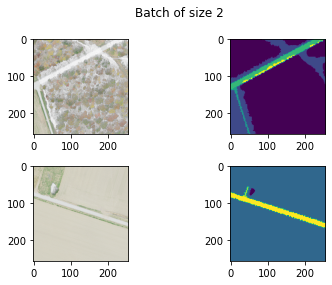

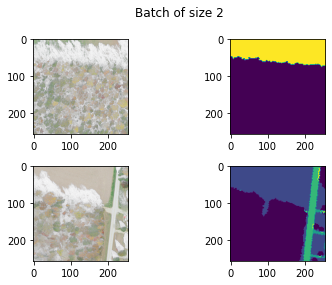

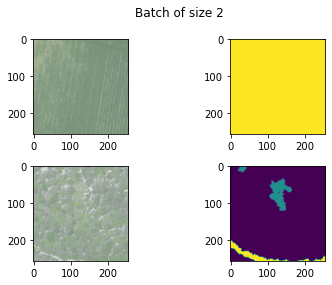

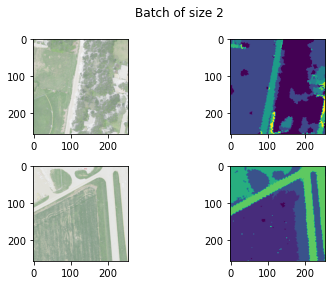

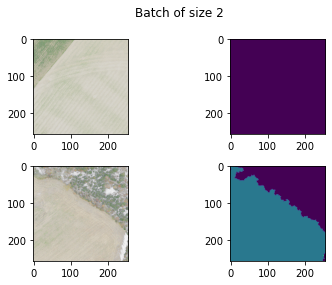

In [130]:
for sample in dataloader:
    image = sample["image"]
    print(image.shape)
    target = sample["mask"]
    # print(image)
    # print(image.shape)
    out = call_model(checkpoint_model, image[:,:3,:,:].to(torch.float32))
    print(type(out))
    print(out.shape)
    print(image.shape)
    fig, ax = plt.subplots(2,2)
    plt.suptitle(f"Batch of size {image.shape[0]}")
    ax[0][0].imshow(image[0].numpy().squeeze().transpose(1,2,0))
    ax[0][1].imshow(target[0].numpy().squeeze())
    ax[1][0].imshow(image[1].numpy().squeeze().transpose(1,2,0))
    ax[1][1].imshow(target[1].numpy().squeeze())
    
    plt.tight_layout()

## Visualize all rasters in our stack
* Want to turn this into an inspection tool for the `pc_laz_prep_full.sh script`

In [6]:
example_dir = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip"
tiffs = list(glob.glob(os.path.join(example_dir, "*.tif")))

In [168]:
print(tiffs)

['/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/1020010042D39D00.r100_ortho_1.0m_ba.tif', '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM_hole_fill.tif', '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/USGS_LPC_WA_MtBaker_2015_10UEU8598_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_pc_align_tr-trans_source_1.0m-DEM_diff.tif', '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/1020010043455300.r100_ortho_1.0m_ba.tif', '/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/pc_align_tr-trans_source_1.0m-DEM.tif', 

In [7]:
orthos = list(glob.glob(os.path.join("/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset", "**", "files_to_zip", "*ortho*.tif"), recursive=True))
for ortho_fn in orthos:
    ortho = rioxarray.open_rasterio(ortho_fn)
    print(ortho_fn, "mean:", ortho.data.mean(), "std:", ortho.data.std(), "range:", ortho.data.min(), ortho.data.max())

/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220315_easton_8599/lower_easton3/files_to_zip/1020010042D39D00.r100_ortho_1.0m_ba.tif mean: 542.7077950877856 std: 320.0266918024296 range: 0 1616
/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220315_easton_8599/lower_easton3/files_to_zip/1020010043455300.r100_ortho_1.0m_ba.tif mean: 480.1477004131277 std: 310.15450145198736 range: 0 1513
/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/1020010042D39D00.r100_ortho_1.0m_ba.tif mean: 286.9667060070512 std: 126.19761845447256 range: 0 1471
/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_dataset/pc_laz_prep_full_outputs_20220314_easton_original_bounds/lower_easton3/files_to_zip/1020010043455300.r100_ortho_1.0m_ba.tif mean: 233.74299417196724 std: 132.12474797572878 range: 0 1334
/mnt/1.0_TB_VOLUME/sethv/shashank_data/torchgeo_datase

(1, 971, 959)
(1, 972, 960)
(1, 972, 960)
(1, 971, 959)
(1, 972, 960)


/mnt/1.0_TB_VOLUME/sethv/miniconda3/envs/p310/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(1, 972, 960)
(1, 972, 960)
(1, 972, 960)


/mnt/1.0_TB_VOLUME/sethv/miniconda3/envs/p310/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(1, 972, 960)
(1, 972, 960)


/mnt/1.0_TB_VOLUME/sethv/miniconda3/envs/p310/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(1, 972, 960)


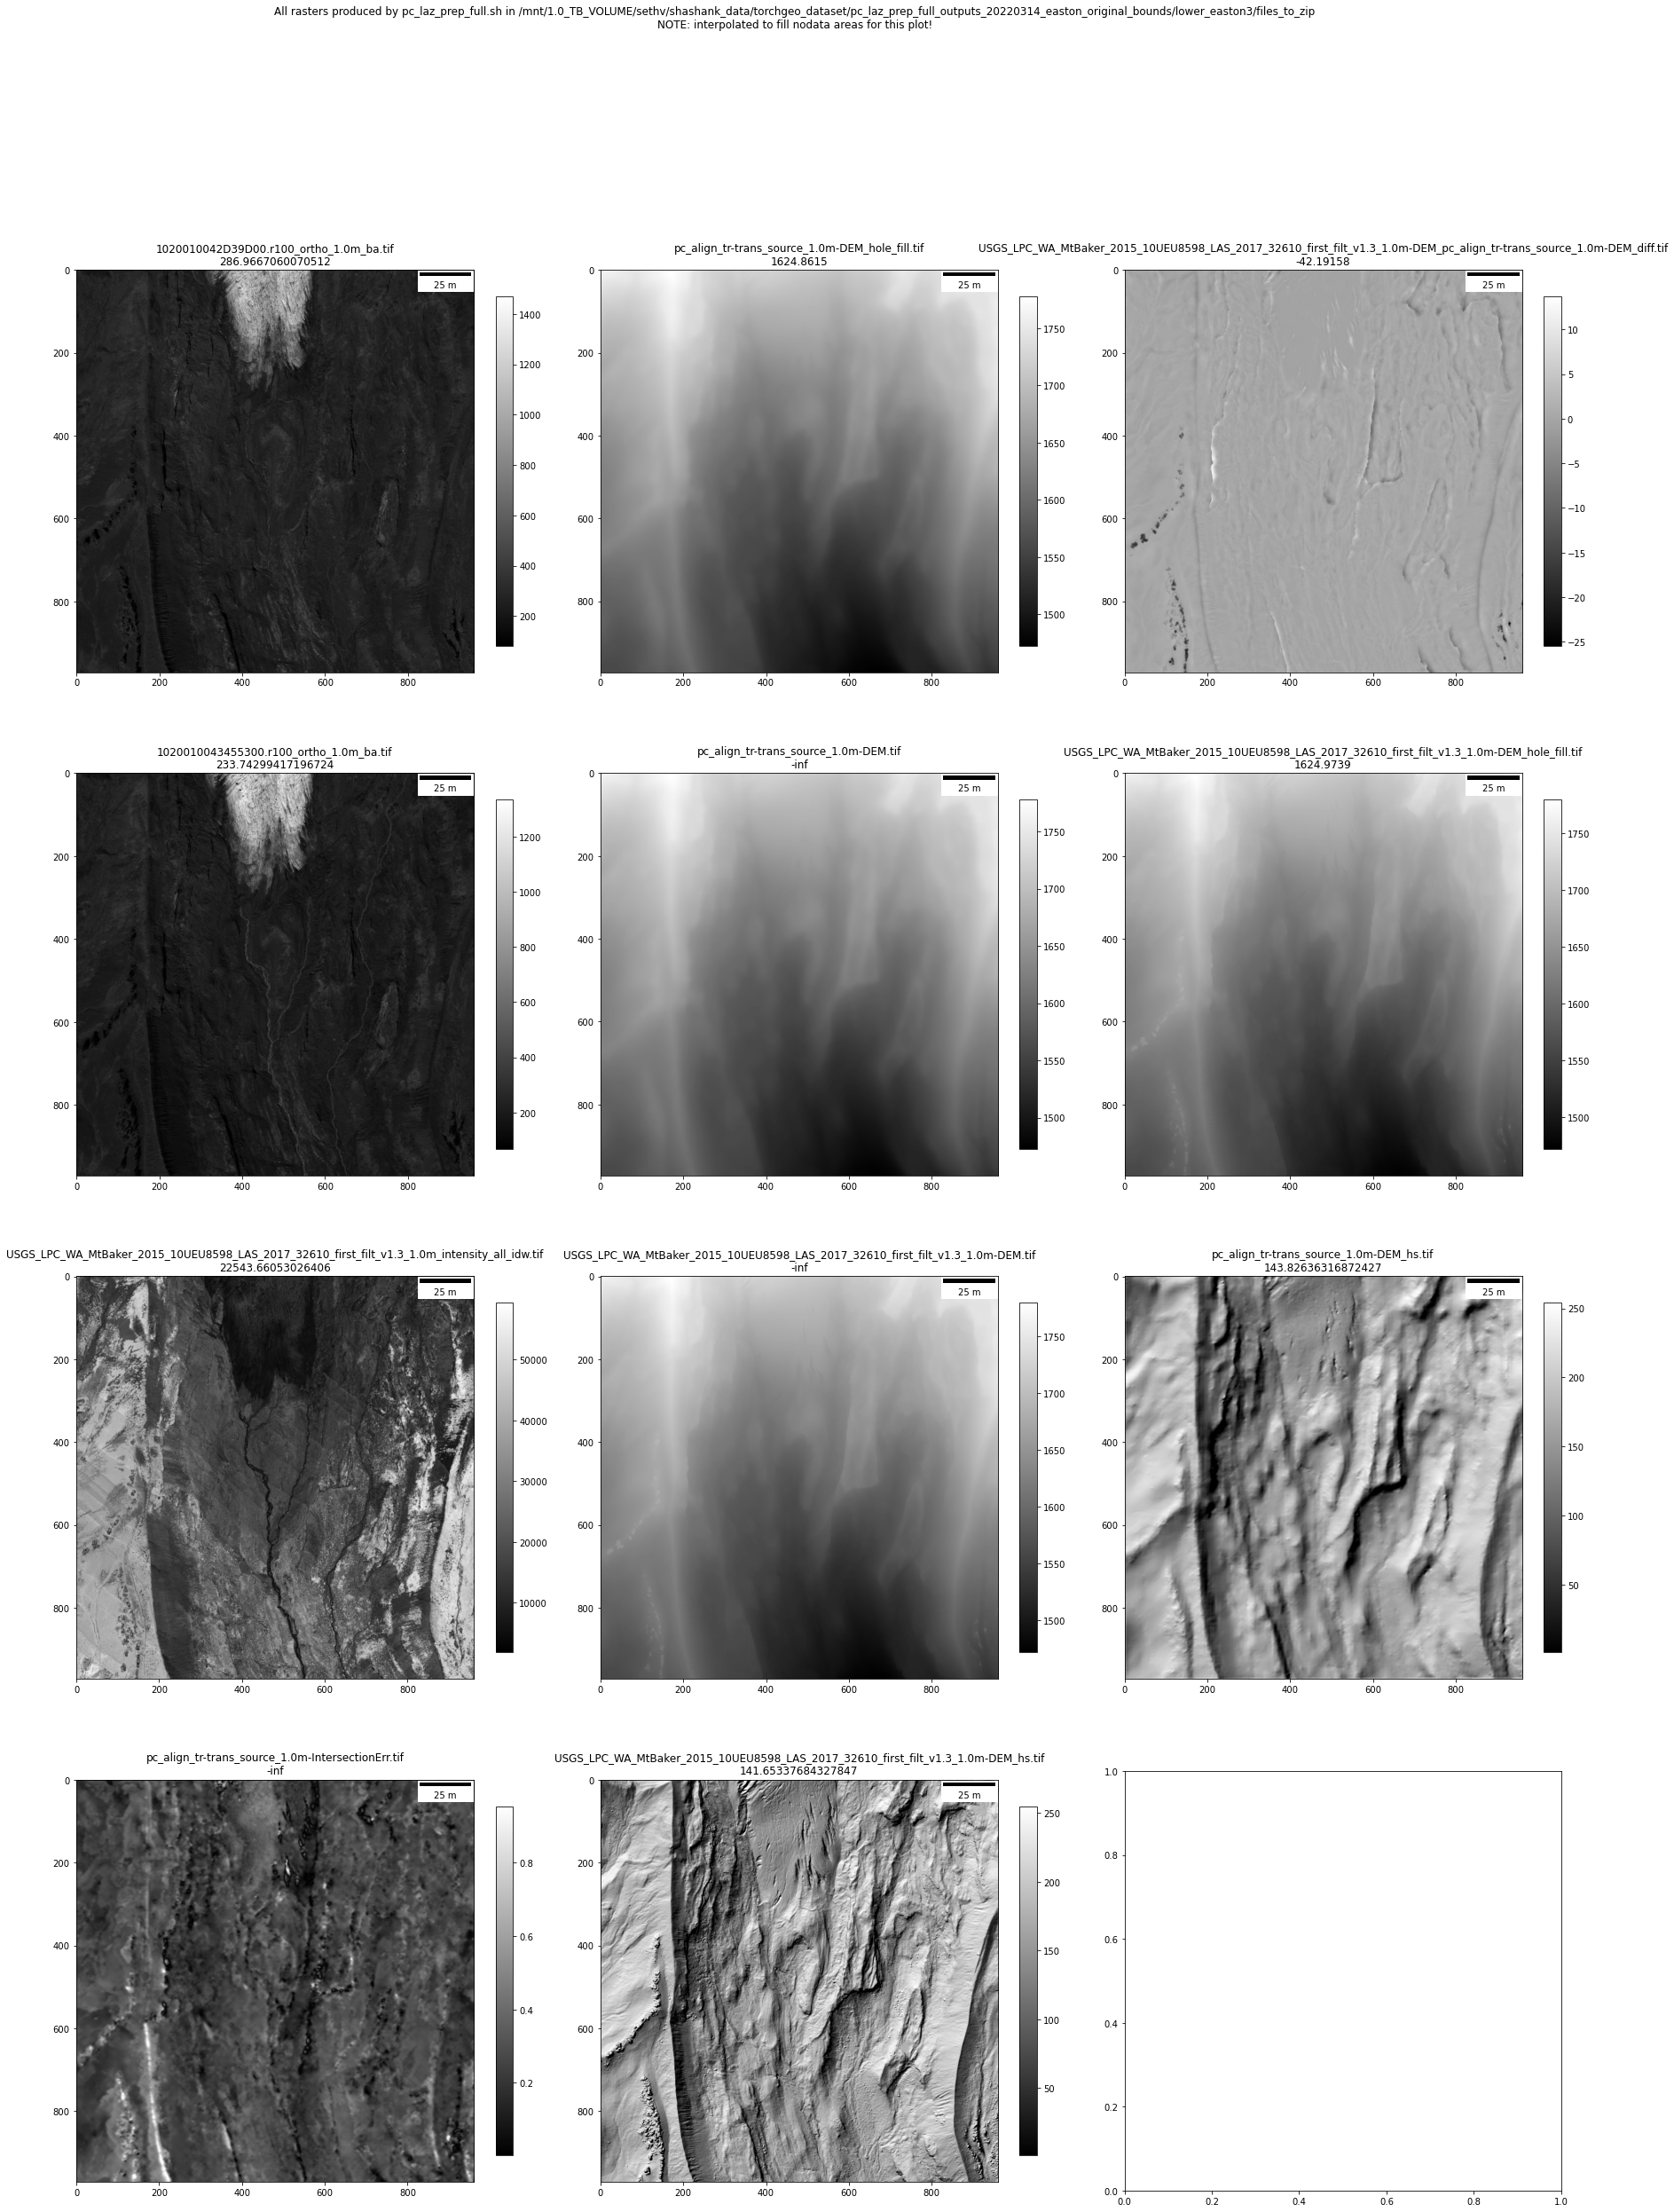

In [8]:

ncols = 3
nrows = math.ceil(len(tiffs) / ncols)
fig,ax = plt.subplots(nrows, ncols, figsize=(10*ncols,10*nrows))
plt.suptitle("\n".join([
    f"All rasters produced by pc_laz_prep_full.sh in {example_dir}",
    "NOTE: interpolated to fill nodata areas for this plot!"
]))

for idx,fn in enumerate(tiffs):
    i,j = int(idx / ncols), int(idx % ncols)
    raster = rioxarray.open_rasterio(fn)
    # TODO handle nodata, for now I want to see it!
    raster_filled = raster.rio.interpolate_na()
    print(raster_filled.data.shape)
    # disable interpolation
    
    # Scalebar disabled for being

    ax[i][j].set_aspect(raster.data.shape[2] / raster.data.shape[1]) # TODO wrong ordering???
    im = ax[i][j].imshow(raster_filled.data.squeeze(), cmap="gray", rasterized=True)
    ax[i][j].set_title("\n".join([os.path.basename(fn), str(raster.data.mean())]))
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")
    ax[i][j].add_artist(ScaleBar(0.2))
    plt.colorbar(im, ax=ax[i][j], fraction=0.04)
    
# plt.tight_layout() # messes up text

## Curious about dataset with hyperspectral + CHM + las files for tree delineation

In [207]:
# !pip install laspy open3d
from torchgeo.datasets import IDTReeS

In [212]:
idtrees = IDTReeS("idtrees_dataset", download=True)

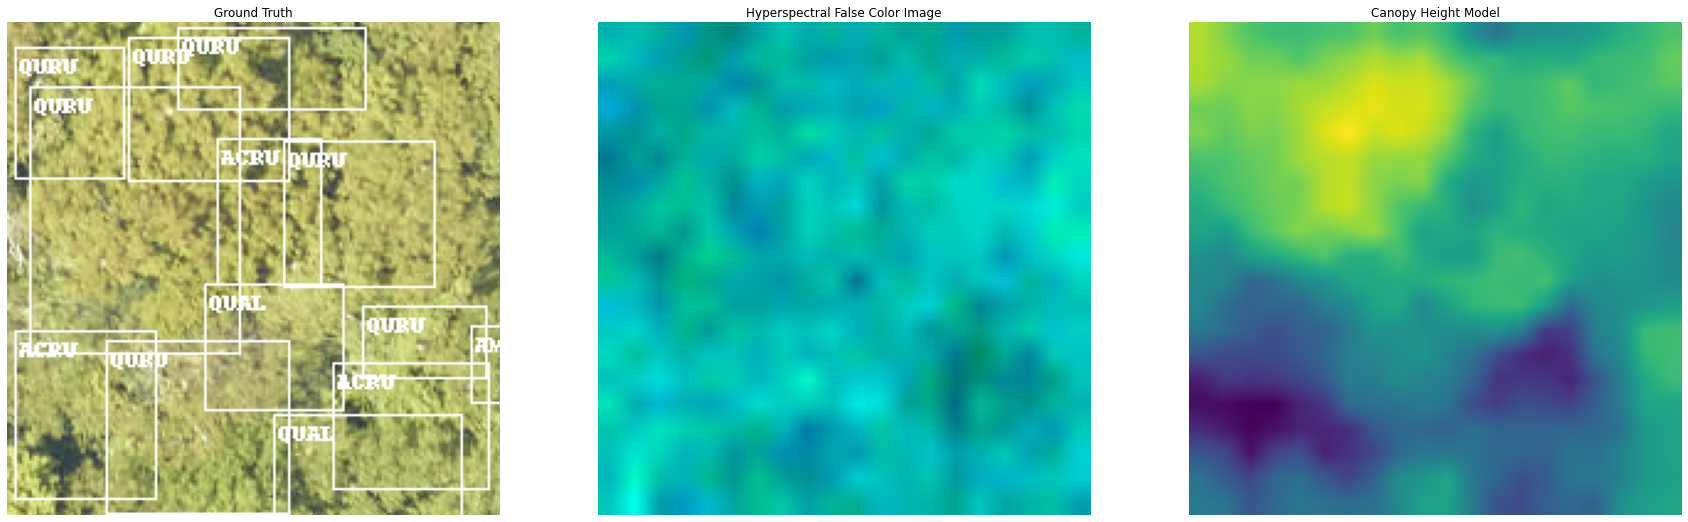

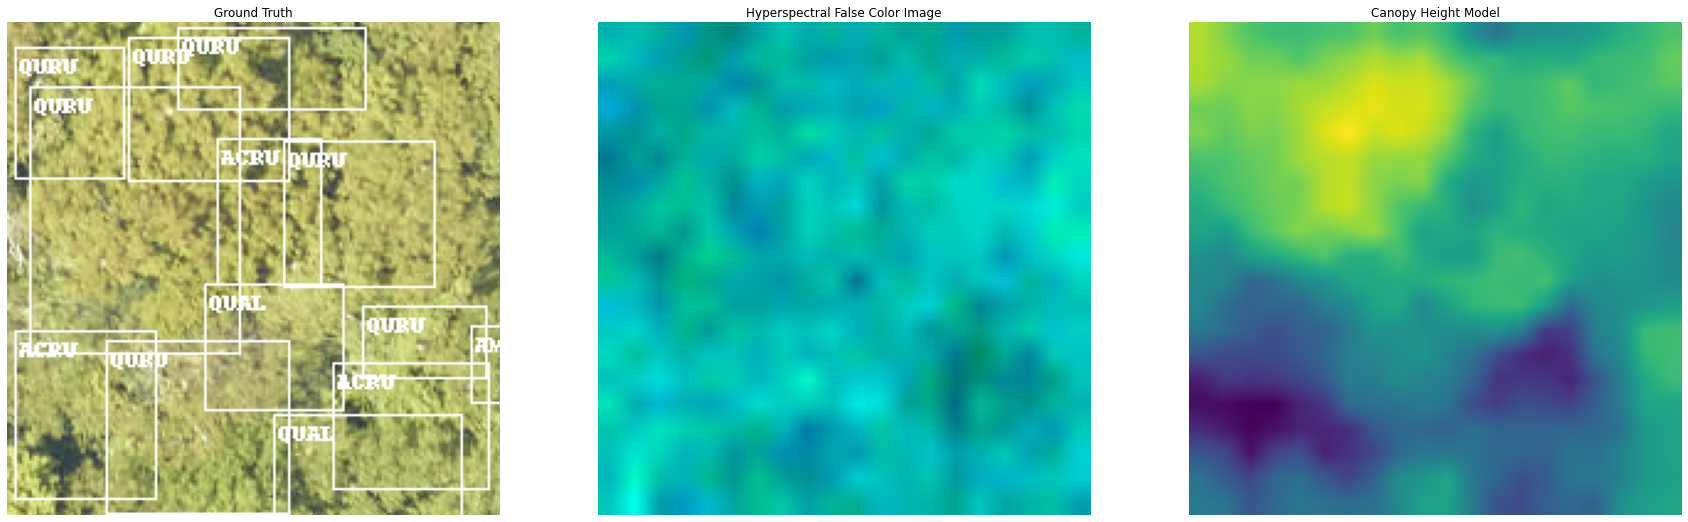

In [219]:
idtrees.plot(idtrees.__getitem__(0))

In [220]:
idtrees.plot_las(0)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


Visualizer with name Open3D